In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime

In [3]:
#DEAR -> REPORTS -> SALES BY PRODUCT DETAILS -> [select time frame] -> EXPORT -> EXCEL WITHOUT TOTALS

df = pd.read_excel('2021details.xlsx',engine='openpyxl',header=0,skiprows=5, parse_dates=False)#parse_dates didn't work, see below
#print(df.iloc[38:45])#head is full of junk right now lol

#### verify sku and product name always perfectly match before dropping sku

In [4]:
#initial cleaning
list_of_retail_stores = ['Customer Square ' + str(x) for x in range(1,4)] #we have 3 stores active, we won't count the Warehouse
retail_names = ['Airport','PleasantValley','OakHill']
df = df[df.Customer.isin(list_of_retail_stores) & df.Product.notnull()].reset_index(drop=True) #remove wholesale and weird null anomoly entries

In [5]:
#df['SKU'] = df.SKU.apply(str)
temp = df.groupby(["Product","SKU"]).count().reset_index()
temp[temp['Product'].duplicated()]

,Product,SKU,Category,Invoice Date,Customer,Quantity,Sale,COGS,Profit
2635,La Venenosa Raicilla Tutsi 750ml,799599687865,2,2,2,2,2,2,2


#### Looks like La Venenosa Tutsi (output of the above cell) is screwed up in DEAR and needs a fix. Otherwise we can assume that for each product and sku, there is only one pair. Thus, we don't need both columns (but we need to fix Tutsi and re-run the report in DEAR). While I should do the remainder by SKU, I'm lazy and want easy to read things so screw Tutsi, we're dropping SKU and going by Product Name. NOT IDEAL

In [6]:
#start cleaning some of the unused or needed columns / rows, converting "Invoice Date" to datetime objects
df = df.drop(['SKU', 'COGS','Profit'], axis=1, inplace=False)#not trusted data columns or useful, we'll ignore them for now
df = df.rename(columns={'Invoice Date':'Date'})#renaming for legibility 
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')#get these dates converted from string to something more powerful
df['Month'] = df.Date.apply(lambda x: x.month)#.month_name() also an option but i dont trust yet
df['Weekday'] = df.Date.apply(lambda x: x.dayofweek)#Monday is 0, Sunday is 6, day_name() also an option but i dont trust yet
df["Unit"] = df.Sale / df.Quantity
df.head()

,Product,Category,Date,Customer,Quantity,Sale,Month,Weekday,Unit
0,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-02-06,Customer Square 2,1,67.99,2,5,67.99
1,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-10,Customer Square 2,1,67.99,3,2,67.99
2,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-17,Customer Square 2,1,67.99,3,2,67.99
3,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 1,1,67.99,5,5,67.99
4,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 2,1,67.99,5,5,67.99


In [7]:
#quick wine filter setup and check to make sure there's no items with bad categories that need fixing
active_categories = df.Category.unique().tolist()
active_categories.sort()
#print(active_categories)
wine_list = ['White','Orange Wine','Bubbles','Red New World','Red Old World','Rose']#active categories just for vino
whiskey_list = ['Whiskey American Single Malt', 'Whiskey Bourbon/American', 'Whiskey Canadian', 'Whiskey French', 'Whiskey Indian', 'Whiskey Irish', 'Whiskey Japanese', 'Whiskey Mexican', 'Whiskey Rye', 'Whiskey Scotch', 'Whiskey Taiwaneese', 'Whisky German']
#if there's bad categories (at item creation in DEAR) fix in DEAR and re-run report - easiest for now or manually edit here
###print(df.groupby(['Product','Customer',(pd.Grouper(key='Date', freq='1M'))]).Quantity.sum().head()) #example

In [8]:
#I was having some weird data issues, was troubleshooting here but it's kinda interesting to see
#df[df.Product != 'Discount'].sort_values(by="Sale",ascending = False).head(15)

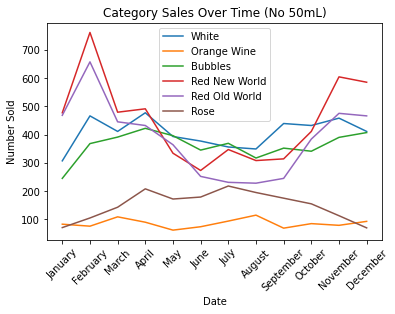

In [9]:
#lets make a plot showing the change in category sales over the year
linegraph = df[df["Product"].str.contains(" 50m")==False] #remove minis
linegraph = linegraph.groupby(['Category','Month']).Quantity.sum().reset_index()#example, (pd.Grouper(key='Date', freq='1M')) gave some weird results for January and doing by raw month should allow for multiple years later
#print(linegraph.iloc[9:15])

months=["January","February","March","April","May","June","July","August","September","October","November","December"]
test_list = ["Rum","Mezcal","Whiskey Scotch","Gin","Sake"]

fig, ax = plt.subplots()
for cat in wine_list:
    ax.plot(linegraph[linegraph.Category == cat].Month,linegraph[linegraph.Category == cat].Quantity,label = cat)

#ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))#copy pasted from somewhere
#ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.set_xticks(range(1,13))
ax.set_xticklabels(months,rotation=45)
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Category Sales Over Time (No 50mL)')
plt.legend()#show it!
plt.show()


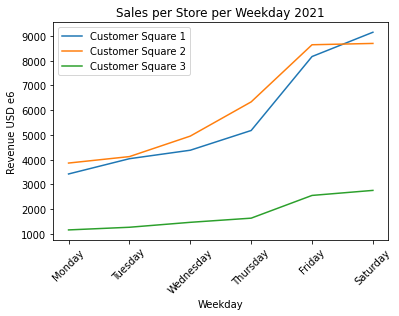

In [10]:
#lets show each store by day
#print(df[df["Weekday"]==6].head())# should we drop gift cards entirely? do they get double counted for revenue on these reports?
square = df[df['Weekday']!=6].groupby(['Customer','Weekday']).Sale.sum().reset_index()

fig, ax = plt.subplots()
for store in list_of_retail_stores:
    ax.plot(square[square['Customer']==store].Weekday,(square[square['Customer']==store].Sale / 52),label=store)

ax.set_xticks(range(0,6))
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],rotation=45)
plt.xlabel('Weekday')
plt.ylabel('Revenue USD e6')
plt.title('Sales per Store per Weekday 2021')
plt.legend()#show it!
plt.show()


hist = df[df["Product"].str.contains(" 50m|Discount")==False].groupby('Product').agg({'Unit':'max','Quantity':'sum'}).reset_index()
hist = hist.sort_values(by='Unit')
print(hist.head())
plt.scatter(hist.Unit,hist.Quantity)
plt.xlim([0, 50])
plt.show()
hist[hist.Quantity > 8000]

GROUP BY PRICE

                              Product   Unit  Quantity
0                       1 Water 355ml   1.50         7
1     123 Organic Anejo Tequila 750ml  59.99        10
2    123 Organic Blanco Tequila 750ml  47.99        11
3  123 Organic Reposado Tequila 750ml  56.99         8
4         17/24 Metodo Classico 750ml  42.99        36
          index   bins
0       (0, 10]  73548
1      (10, 18]  43191
2      (25, 40]  36145
3      (18, 25]  35325
4      (40, 75]  18381
5     (75, 100]   2560
6    (100, 200]   2106
7    (200, 500]    353
8  (500, 10000]     17


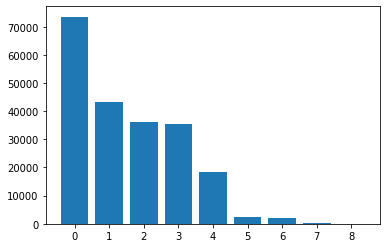

In [55]:
#lets do a histogram for item sales by price bracket, tequila let's go?

#hist = df.groupby('Product').agg({'Unit':'max','Quantity':'sum','Category':'first'}).reset_index()
hist = df[df["Product"].str.contains(" 50m")==False].groupby('Product').agg({'Unit':'max','Quantity':'sum'}).reset_index()
#hist["Price"] = hist.apply(find_price,axis=1)
print(hist.head())
hist_dump = []
for index, row in hist.iterrows():
    if True: #could put a filter here like category
        for i in range(0,row.Quantity):
            hist_dump.append(row.Unit)
hist_dump[0:(hist.Quantity.iloc[0]+1)]#show that its working

#testing this out as a hist for practice
bins = [0,10,18,25,40,75,100,200,500,10000]
mydata = pd.DataFrame(hist_dump)
mydata["bins"] = pd.cut(mydata[0], bins)
mydata = mydata.bins.value_counts().reset_index()
print(mydata)

fig, ax = plt.subplots()

plt.bar(mydata.index,mydata.bins, align='center')
plt.xticks(mydata.index)
ax.set_xticklabels(mydata.index) # FIX THIS LINE
#mydata["bins"].value_counts().plot.bar(align='center')
plt.show()

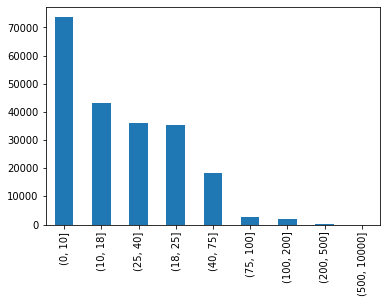

## Shelf Space Allocation Efficiency

In [ ]:
#comparing how many we have of each category vs how well that sells (shelf space allocation)
sku_start = df[df["Product"].str.contains(" 50m")==False] #remove minis
sku_start = sku_start[sku_start['Category'].str.contains("Fruit|Service|Ice") == False]#these categories dont take space, add more
#sku_start["Revenue"] = sku_start.Quantity * sku_start.Price
print(sku_start.head())

sku_space = sku_start.groupby('Category').Product.unique().reset_index()
sku_space['Count'] = sku_space.apply(lambda x: np.size(x.Product) ,axis=1)
sku_space['Percent'] = sku_space.apply(lambda x: x.Count / sku_space.Count.sum(), axis=1)
#print(sku_space.head())

sku_volume = sku_start.groupby('Category').Quantity.sum().reset_index()
sku_volume['Percent'] = sku_volume.apply(lambda x: x.Quantity / sku_volume.Quantity.sum(),axis=1)
#print(sku_volume.head())

sku_revenue = sku_start.groupby('Category').Sale.sum().reset_index()
sku_revenue['ofIncome'] = sku_revenue.Sale / sku_revenue.Sale.sum()
print(sku_revenue.head())

sku_look = sku_space.drop(['Product','Count'],axis=1)#cleaning unused row
sku_look['ofSales'] = sku_volume.Percent #combining things
sku_look.rename(columns={'Percent':'ofSpace'},inplace=True) 
sku_look['RatioSpace'] = sku_look.ofSales / sku_look.ofSpace #high number is a GOOD performer
sku_look.sort_values(by=['Category'],inplace=True,ascending=True)
sku_look['ofIncome'] = sku_revenue['ofIncome']
sku_look['RatioSales'] = sku_look.ofIncome / sku_look.ofSpace
sku_look.to_csv('shelfspaceallocation.csv',index=False)